## Proportional Sampling - Nulls Dropped

In [17]:
import pandas as pd 
import numpy as np                     
import seaborn as sns                  
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
train_original = pd.read_csv(r"C:\Users\Ethan\Downloads\loan_sanction_train.csv")
train = train_original.copy()
train.head()

test_original = pd.read_csv(r"C:\Users\Ethan\Downloads\loan_sanction_test.csv")
test = test_original.copy()

In [19]:
#Drop Loan_ID:
train = train.drop('Loan_ID', axis = 1)
test = test.drop('Loan_ID', axis = 1)

#Encode Gender M/F into 1/0:
train['Gender'].replace('Male',1,inplace=True)
train['Gender'].replace('Female',0,inplace=True)
test['Gender'].replace('Male',1,inplace=True)
test['Gender'].replace('Female',0,inplace=True)

#Encode Married Y/N into 1/0:
train['Married'].replace('Yes',1,inplace=True)
train['Married'].replace('No',0,inplace=True)
test['Married'].replace('Yes',1,inplace=True)
test['Married'].replace('No',0,inplace=True)

#Encode Dependents into numerical data:
train['Dependents'].replace('0',0,inplace=True)
test['Dependents'].replace('0',0,inplace=True)
train['Dependents'].replace('1',1,inplace=True)
test['Dependents'].replace('1',1,inplace=True)
train['Dependents'].replace('2',2,inplace=True)
test['Dependents'].replace('2',2,inplace=True)
train['Dependents'].replace('3+',3,inplace=True)
test['Dependents'].replace('3+',3,inplace=True)

#Encode Education Graduate/Not Graduate into 1/0
train['Education'].replace('Graduate',1,inplace = True)
train['Education'].replace('Not Graduate',0,inplace = True)
test['Education'].replace('Graduate',1,inplace = True)
test['Education'].replace('Not Graduate',0,inplace = True)

#Encode Self-Employed Y/N into 1/0:
train['Self_Employed'].replace('Yes',1,inplace = True)
train['Self_Employed'].replace('No',0,inplace = True)
test['Self_Employed'].replace('Yes',1,inplace = True)
test['Self_Employed'].replace('No',0,inplace = True)

#Encode Property_Area values Rural, Semiurban, Urban into 0/1/2:
train['Property_Area'].replace('Rural',0,inplace = True)
train['Property_Area'].replace('Semiurban',1,inplace = True)
train['Property_Area'].replace('Urban',2,inplace = True)
test['Property_Area'].replace('Rural',0,inplace = True)
test['Property_Area'].replace('Semiurban',1,inplace = True)
test['Property_Area'].replace('Urban',2,inplace = True)

train['Loan_Status'].replace('Y',1,inplace=True)
train['Loan_Status'].replace('N',0,inplace=True)



In [20]:
class_proportions = train['Loan_Status'].value_counts(normalize=True)
desired_proportions = {1: 0.6, 0: 0.4}
target_counts = {cls: int(desired_proportions[cls] * len(train)) for cls in desired_proportions}
train5050 = pd.DataFrame()
for cls, target_count in target_counts.items():
    class_data = train[train['Loan_Status'] == cls]
    sampled_data = class_data.sample(n=target_count, replace=True)  # Adjust replace parameter as needed
    train5050 = pd.concat([train5050, sampled_data], axis=0)

train5050_class_proportions = train5050['Loan_Status'].value_counts(normalize=True)
train5050_class_proportions

train5050 = train5050.dropna()
train5050.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Handling Outliers

In [21]:
import numpy as np
train = train[train['CoapplicantIncome']<10000]

for col in ['LoanAmount','ApplicantIncome']:
    train[col] = train[col].apply(np.log1p)

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [23]:
X = train5050.drop('Loan_Status', axis=1)
y = train5050['Loan_Status']
#Note: The test csv file actually doesn't have a Loan Status column, so it's worthless as far as making predictions go. Instead, let's split our trianing data.
#X_test = test.drop('Loan_Status', axis = 1)
#y_test = test['Loan_Status']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.34)

Accuracy: 0.79
Cross-Validation Scores: [0.7755102  0.7755102  0.70833333 0.75       0.77083333 0.72916667
 0.72916667 0.77083333 0.70833333 0.6875    ]
Mean Accuracy: 0.7405187074829931

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.62      0.70        65
           1       0.78      0.91      0.84        99

    accuracy                           0.79       164
   macro avg       0.80      0.76      0.77       164
weighted avg       0.80      0.79      0.79       164


Confusion Matrix:
[[40 25]
 [ 9 90]]


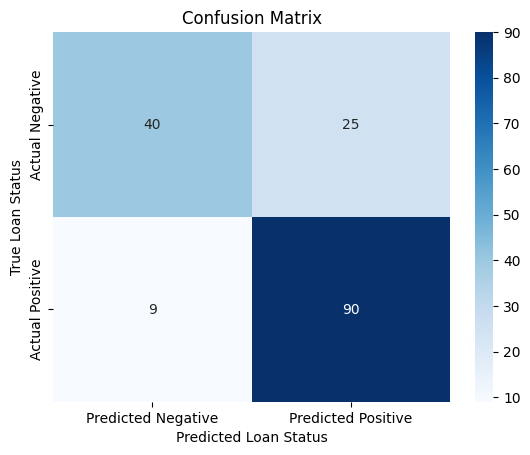

              Feature  Importance
7          LoanAmount        0.36
9      Credit_History        0.31
1             Married        0.17
5     ApplicantIncome        0.06
8    Loan_Amount_Term        0.06
2          Dependents        0.02
10      Property_Area        0.02
0              Gender        0.00
3           Education        0.00
4       Self_Employed        0.00
6   CoapplicantIncome        0.00


In [24]:
base_classifier = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_classifier, n_estimators=100,learning_rate = 0.05, random_state=42)
bagging_adaboost_model = BaggingClassifier(base_estimator=adaboost_model, n_estimators=10, random_state=42)
adaboost_model.fit(X_train, y_train)
#bagging_adaboost_model.fit(X_train, y_train)
y_pred = adaboost_model.predict(X_test)
#y_pred = bagging_adaboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cv_scores = cross_val_score(adaboost_model, X, y, cv=10)

# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Loan Status')
plt.ylabel('True Loan Status')
plt.show()

feature_importances = adaboost_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importances
print(feature_importance_df)

In [25]:
from xgboost import XGBClassifier

Accuracy: 0.76
Cross-Validation Scores: [0.7755102  0.7755102  0.70833333 0.77083333 0.72916667 0.72916667
 0.72916667 0.77083333 0.6875     0.6875    ]
Mean Accuracy: 0.7363520408163265

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.46      0.60        65
           1       0.73      0.95      0.82        99

    accuracy                           0.76       164
   macro avg       0.79      0.71      0.71       164
weighted avg       0.78      0.76      0.74       164


Confusion Matrix:
[[30 35]
 [ 5 94]]
              Feature  Importance
9      Credit_History    0.652896
1             Married    0.205198
7          LoanAmount    0.090788
5     ApplicantIncome    0.051117
0              Gender    0.000000
2          Dependents    0.000000
3           Education    0.000000
4       Self_Employed    0.000000
6   CoapplicantIncome    0.000000
8    Loan_Amount_Term    0.000000
10      Property_Area    0.000000


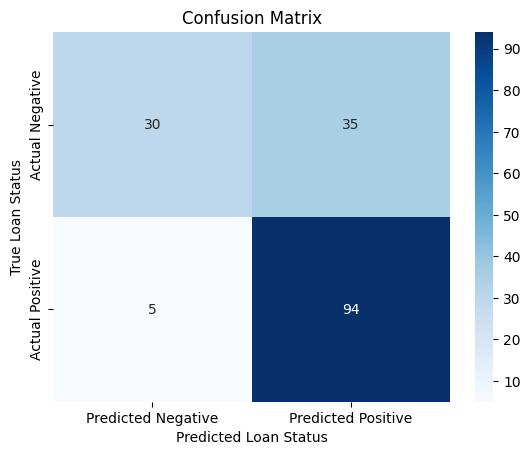

In [26]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=2, learning_rate=0.01, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

cv_scores = cross_val_score(xgb_model, X, y, cv=10)

# Display the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

feature_importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importances
print(feature_importance_df)

conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Loan Status')
plt.ylabel('True Loan Status')
plt.show()